# Predicting Flu Vaccine Compliance

# Overview

The CDC has provided the National 2009 H1N1 Flu Survey. They want to pull out the **most useful features** from this model in order to later create **a new survey** on compliance with COVID-19 vaccines. 

### Business Problem

Creating a model to pull out features that best predict who will get the seasonal flu vaccine. 

### Dataset Size 

The initial dataset was 26,707 rows with 36 columns. After initial data cleaning there were 27 columns. 

### Limitations of the Dataset

The data was collected via telephone surveys, a commonly used polling method which is not representative or random (as people choose to respond or not when they are called). Additionally, new surveys and models may need to take into account the anti-vaccine movement (article [here](https://pubmed.ncbi.nlm.nih.gov/16039769/)) which was not as prevalent when the data was collected in 2009, as well as the cultural and behavioral shifts that have occurred due Covid-19. Finally, this dataset has a large amount of missing responses that need to be dealt with in order to model the data. We will discuss this in depth later on in the notebook. 


### Why We Used This Dataset

Despite the above limitations, the dataset does contain a large number of responses on and takes into account a large number of features relevant to seasonal flu vaccine compliance, and is a relatively recent dataset. For all these reasons, we decided to use this dataset to create our predictive model. 


# Looking at the Data

## Imports

In [1]:
# imports
import numpy as np
import pandas as pd
import statistics
import scipy.sparse
import xgboost
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency
from xgboost import XGBClassifier

from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.dummy import DummyClassifier

# so we can change the random state thoughout the code all at once (if we want) 
RANDOM_STATE = 42


## Data: Initial Look

In [2]:
features = pd.read_csv("Data/training_set_features.csv")
labels = pd.read_csv("Data/training_set_labels.csv")

In [3]:
#checking if the features and lable dataframes match up 
np.testing.assert_array_equal(features.index.values, labels.index.values)

In [4]:
#lets look at the features data
features.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [5]:
# basic descriptive information on the features
features.describe()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children
count,26707.000000,26615.000000,26591.000000,26636.000000,26499.000000,26688.000000,26665.000000,26620.00000,26625.000000,26579.000000,...,25903.000000,14433.00000,26316.000000,26319.000000,26312.000000,26245.000000,26193.000000,26170.000000,26458.000000,26458.000000
mean,13353.000000,1.618486,1.262532,0.048844,0.725612,0.068982,0.825614,0.35864,0.337315,0.677264,...,0.111918,0.87972,3.850623,2.342566,2.357670,4.025986,2.719162,2.118112,0.886499,0.534583
std,7709.791156,0.910311,0.618149,0.215545,0.446214,0.253429,0.379448,0.47961,0.472802,0.467531,...,0.315271,0.32530,1.007436,1.285539,1.362766,1.086565,1.385055,1.332950,0.753422,0.928173
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,6676.500000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,...,0.000000,1.00000,3.000000,1.000000,1.000000,4.000000,2.000000,1.000000,0.000000,0.000000
50%,13353.000000,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000,0.000000,1.000000,...,0.000000,1.00000,4.000000,2.000000,2.000000,4.000000,2.000000,2.000000,1.000000,0.000000
75%,20029.500000,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.00000,1.000000,1.000000,...,0.000000,1.00000,5.000000,4.000000,4.000000,5.000000,4.000000,4.000000,1.000000,1.000000
max,26706.000000,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,...,1.000000,1.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,3.000000


In [6]:
# Now lets look into the labels data
labels.head()


,respondent_id,h1n1_vaccine,seasonal_vaccine
0,0,0,0
1,1,0,1
2,2,0,0
3,3,0,1
4,4,0,0


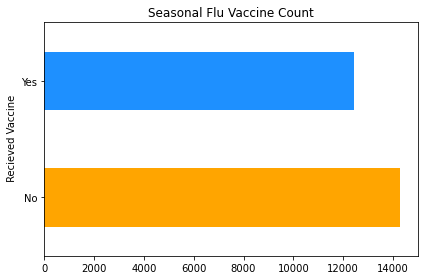

In [7]:
# small bar graph comparing who recieved the vaccine and who didn't
fig, ax = plt.subplots()
labels['seasonal_vaccine'].value_counts().plot.barh(title="Seasonal Flu Vaccine Count", color = ["orange", "dodgerblue"])
ax.set_yticklabels(["No", "Yes"])
ax.set_ylabel(" Recieved Vaccine")
fig.tight_layout()

From the above graph, we can see our dependent variable (`labels['seasonal_vaccine']`) is pretty evenly split. 

In [8]:
print("Percentage of People Vaccinated (0 = no, 1 = yes)")
(labels['seasonal_vaccine'].value_counts(normalize = True)*100)

Percentage of People Vaccinated (0 = no, 1 = yes)


0    53.439173
1    46.560827
Name: seasonal_vaccine, dtype: float64

So around 47% of respondants were vaccinated, and around 53% were not.

### Description of Features

In [9]:
# Looking further into the `features` DataFrame
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

Descriptions of the features (taken from [here](https://www.drivendata.org/competitions/66/flu-shot-learning/page/211/)): 

For all binary variables: 0 = No; 1 = Yes.

- h1n1_concern - Level of concern about the H1N1 flu. 0 = Not at all concerned; 1 = Not very concerned; 2 = Somewhat concerned; 3 = Very concerned.
- h1n1_knowledge - Level of knowledge about H1N1 flu. 0 = No knowledge; 1 = A little knowledge; 2 = A lot of knowledge.
- behavioral_antiviral_meds - Has taken antiviral medications. (binary)
- behavioral_avoidance - Has avoided close contact with others with flu-like symptoms. (binary)
- behavioral_face_mask - Has bought a face mask. (binary)
- behavioral_wash_hands - Has frequently washed hands or used hand sanitizer. (binary)
- behavioral_large_gatherings - Has reduced time at large gatherings. (binary)
- behavioral_outside_home - Has reduced contact with people outside of own household. (binary)
- behavioral_touch_face - Has avoided touching eyes, nose, or mouth. (binary)
- doctor_recc_h1n1 - H1N1 flu vaccine was recommended by doctor. (binary)
- doctor_recc_seasonal - Seasonal flu vaccine was recommended by doctor. (binary)
- chronic_med_condition - Has any of the following chronic medical conditions: asthma or an other lung condition, diabetes, a heart condition, a kidney condition, sickle cell anemia or other anemia, a neurological or neuromuscular condition, a liver condition, or a weakened immune system caused by a chronic illness or by medicines taken for a chronic illness. (binary)
- child_under_6_months - Has regular close contact with a child under the age of six months. (binary)
- health_worker - Is a healthcare worker. (binary)
- health_insurance - Has health insurance. (binary)
- opinion_h1n1_vacc_effective - Respondent's opinion about H1N1 vaccine effectiveness. 1 = Not at all effective; 2 = Not very effective; 3 = Don't know; 4 = Somewhat effective; 5 = Very effective.
- opinion_h1n1_risk - Respondent's opinion about risk of getting sick with H1N1 flu without vaccine.1 = Very Low; 2 = Somewhat low; 3 = Don't know; 4 = Somewhat high; 5 = Very high.
- opinion_h1n1_sick_from_vacc - Respondent's worry of getting sick from taking H1N1 vaccine.1 = Not at all worried; 2 = Not very worried; 3 = Don't know; 4 = Somewhat worried; 5 = Very worried.
- opinion_seas_vacc_effective - Respondent's opinion about seasonal flu vaccine effectiveness.1 = Not at all effective; 2 = Not very effective; 3 = Don't know; 4 = Somewhat effective; 5 = Very effective.
- opinion_seas_risk - Respondent's opinion about risk of getting sick with seasonal flu without vaccine.1 = Very Low; 2 = Somewhat low; 3 = Don't know; 4 = Somewhat high; 5 = Very high.
- opinion_seas_sick_from_vacc - Respondent's worry of getting sick from taking seasonal flu vaccine.1 = Not at all worried; 2 = Not very worried; 3 = Don't know; 4 = Somewhat worried; 5 = Very worried.
- age_group - Age group of respondent.
- education - Self-reported education level.
- race - Race of respondent.
- sex - Sex of respondent.
- income_poverty - Household annual income of respondent with respect to 2008 Census poverty thresholds.
- marital_status - Marital status of respondent.
- rent_or_own - Housing situation of respondent.
- employment_status - Employment status of respondent.
- hhs_geo_region - Respondent's residence using a 10-region geographic classification defined by the U.S. Dept. of Health and Human Services. Values are represented as short random character strings.
- census_msa - Respondent's residence within metropolitan statistical areas (MSA) as defined by the U.S. Census.
- household_adults - Number of other adults in household, top-coded to 3.
- household_children - Number of children in household, top-coded to 3.
- employment_industry - Type of industry respondent is employed in. Values are represented as short random character strings.
- employment_occupation - Type of occupation of respondent. Values are represented as short random character strings.

## Data: Initial Cleaning

Let's remove all of the columns related to only the H1N1 vaccine: h1n1_concern, h1n1_knowledge, doctor_recc_h1n1, opinion_h1n1_vacc_effective, opinion_h1n1_risk, opinion_h1n1_sick_from_vacc

Additionally, there are some columns where the information has been scrambled (presumably to protect the respondents personal information) so lets remove those as well as we can't extract any useful information without knowing what they are coded for: hhs_geo_region, employment_industry, employment_occupation

Finally, let's remove 'h1n1_vaccine' and 'respondent_id' from the labels DataFrame, and then turn the labels dataframe into an array so we can use it when we build our models later on. 

In [10]:
features.drop(['respondent_id', 'h1n1_concern', 'h1n1_knowledge', 'doctor_recc_h1n1',
               'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 
               'opinion_h1n1_sick_from_vacc', 'hhs_geo_region', 
               'employment_industry', 'employment_occupation'],
              axis = 1, inplace = True)

labels.drop(['h1n1_vaccine', 'respondent_id'], axis = 1, inplace= True)
labels_rav = np.ravel(labels, order = 'C')

In [11]:
# train_test_split - creating training, validation, and test sets of data to work with 
X_train, X_test, y_train, y_test = train_test_split(features, labels_rav, test_size=0.2, random_state = RANDOM_STATE)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=RANDOM_STATE)

# Creating Preprocessing Pipeline

In order to create a pipeline for preprocessing, let's first figure out how we will handle our missing values.

In [12]:
features.isnull().sum()

behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
marital_status                  1408
rent_or_own                     2042
employment_status               1463
census_msa                         0
household_adults                 249
household_children               249
dtype: int64

The largest amount of missing data is in `health_insurance` - let's look into the significance of that variable to see if we can drop it. 


In [13]:
cross_tab = pd.crosstab(features['health_insurance'], labels_rav, margins = True)
print(cross_tab)
chi2, p, dof, expected = chi2_contingency(cross_tab)
print(chi2, p)

col_0                0     1    All
health_insurance                   
0.0               1338   398   1736
1.0               5866  6831  12697
All               7204  7229  14433
582.2867466798792 1.0559310374176207e-124


We see above a statistically significant p-value and a very high chi2 value. As such, I decided to keep this feature. 

I've chosen to change all NaN's to 0, as in 2009 when the data was collected the Affordable Care Act had not been passed, so people were not required to have health insurance. I think that keeping the NaN's as 0's is better reflective of this time.

I could have removed the column completely, but then I'd be taking out a statistically significant  column (see above chi2 test). I could have taken out rows that contained the missing data, but there are so many rows missing it would have cut my dataset in half. Replacing the missing data with 1's didn't feel appropriate as healthcare wasn't required at the time. Finally, I could have used a KNN algorithm to sort the missing data into it's most likely option, but choose not to do so for timeliness purposes. 

As for the rest of the missing variables:

 - For the rest of the **binary data** let's also replace all of the missing data with 0's. 
 
 - For the opinion questions and family features (`household_adults` and `household_children`) which are numeric **ordinal and interval data** let's replace all the missing data with the median. Additionally, we will use `MinMaxScaler` to scale this data. 
     - Most of our data is binary, and `MinMaxScaler` will keep the scaled data in the range of 0-1, which is ideal in this case. 
 
 - Finally, for our **categorical data** let's use the mode to replace any missing values, and then we will use `OneHotEncoder` to create dummy categories on all our categorical data.
 
 We will put all of this into a pipeline, so we can test out different models!  


In [14]:
#create functions for preprocessing

# function to replace NaN's in the ordinal and interval data 
def replace_NAN_median(X_df):
    opinions = ['opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'household_adults',
                'household_children']
    for column in opinions:
        X_df[column].replace(np.nan, X_df[column].median(), inplace = True)
    return X_df

# function to replace NaN's in the catagorical data     
def replace_NAN_mode(X_df):
    miss_cat_features = ['education', 'income_poverty', 'marital_status', 'rent_or_own', 'employment_status']
    for column in miss_cat_features:
        X_df[column].replace(np.nan, statistics.mode(X_df[column]), inplace = True)
    return X_df

# function to replace NaN's in the binary data                                
def replace_NAN_0(X_df):
    miss_binary = ['behavioral_antiviral_meds', 'behavioral_avoidance','behavioral_face_mask' ,
    'behavioral_wash_hands', 'behavioral_large_gatherings', 'behavioral_outside_home',
    'behavioral_touch_face', 'doctor_recc_seasonal', 'chronic_med_condition', 
    'child_under_6_months', 'health_worker','health_insurance']
    for column in miss_binary:
        X_df[column].replace(np.nan, 0, inplace = True)
    return X_df

In [15]:
# Instantiate transformers

# I used functions instead of SimpleImputer as the functions preserved  the feature names 
# throughout the pipeline
NAN_median = FunctionTransformer(replace_NAN_median)
NAN_mode = FunctionTransformer(replace_NAN_mode)
NAN_0 = FunctionTransformer(replace_NAN_0)
col_transformer = ColumnTransformer(transformers= [
    # I chose MinMaxScaler vs. StandardScaler in order to keep my data in the binary range (0-1)
    ("scaler", MinMaxScaler(), ['opinion_seas_vacc_effective', 'opinion_seas_risk',
                                'opinion_seas_sick_from_vacc', 
                                'household_adults', 'household_children']),
     
     # OHE catagorical string data
    ("ohe", OneHotEncoder(sparse = False, drop = "first"), ['age_group','education', 'race', 'sex', 
                                'income_poverty', 'marital_status', 'rent_or_own',
                                'employment_status', 'census_msa'])],
    verbose_feature_names_out = False,
    remainder="passthrough")



In [16]:
# Preprocessing Pipeline (Yey!)
preprocessing_pipe = Pipeline(steps=[
    ("NAN_median", NAN_median), 
    ("NAN_mode", NAN_mode),
    ("NAN_0", NAN_0),
    ("col_transformer", col_transformer)
    ])

# Modeling

### Useful Functions 

In [17]:
#creating a function to fit and get a report of how each model performed
def report(model_name, X_train, y_train, X_test, y_test):
    model_name.fit(X_train, y_train) 
    print('Training Accuracy : ',
      accuracy_score(y_train,
                             model_name.predict(X_train))*100)
    print('Test Accuracy : ',
      accuracy_score(y_test,
                             model_name.predict(X_test))*100)
    pred = model_name.predict(X_train)
    print("Training data matrix:")
    print(confusion_matrix(y_train, pred))
    print("Training report matrix:")
    print(classification_report(y_train, pred))

    pred_test = model_name.predict(X_test)
    print("Test data matrix:")
    print(confusion_matrix(y_test, pred_test))

In [18]:
# creating function so we can plot model results
def plot_importance(feat_names, feat_importances, col1_name, col2_name, title, num_features = 15):
    
    # create dataframe
    
    #feature importance is array - we transpose it to make it usable in a DataFrame
    df = pd.concat([pd.DataFrame(feat_names), pd.DataFrame(np.transpose(feat_importances))], axis = 1)
    # specify column names
    df.columns = [col1_name, col2_name]
    # sort by feat_importances
    df_sort1 = df.sort_values(by=col2_name, ascending=False, key = abs).head(num_features)
    df_sorted = df_sort1.sort_values(by=col2_name, ascending=True, key = abs)
    
    # plot bar chart
    plt.figure(figsize=(8,8))
    # color  was choosen because it is similar to the color of the CDC logo
    plt.barh(df_sorted[col1_name], df_sorted[col2_name], align='center', color = "dodgerblue")
    plt.yticks(np.arange(len(df_sorted[col1_name])), df_sorted[col1_name]) 
    plt.xlabel(col2_name)
    plt.ylabel(col1_name)
    plt.title(title);

## Baseline DummyClassifier Model

Lets see how well we would do if our model predicted the most frequent value *every* time - future models will have to perform better than this in order to claim that they contributed any meaningful information about the data. 

In [19]:
# Using our pipeline to instantiate the model
dummy_clf_pipe = Pipeline(steps=[("preprocessing_pipe", preprocessing_pipe),
                                    ("dummy_clf", DummyClassifier(strategy="most_frequent"))])

dummy_clf_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessing_pipe',
                 Pipeline(steps=[('NAN_median',
                                  FunctionTransformer(func=<function replace_NAN_median at 0x0000014B8EB969D0>)),
                                 ('NAN_mode',
                                  FunctionTransformer(func=<function replace_NAN_mode at 0x0000014B8EB96820>)),
                                 ('NAN_0',
                                  FunctionTransformer(func=<function replace_NAN_0 at 0x0000014B8EB96AF0>)),
                                 ('col_transformer',
                                  ColumnTransformer(rem...
                                                                    'opinion_seas_risk',
                                                                    'opinion_seas_sick_from_vacc',
                                                                    'household_adults',
                                                                    'household_children']),
         

In [20]:
# getting the mean accuracy of the model
report(dummy_clf_pipe, X_train, y_train, X_test, y_test)

Training Accuracy :  53.19228608874742
Test Accuracy :  54.1183077499064
Training data matrix:
[[8523    0]
 [7500    0]]
Training report matrix:
              precision    recall  f1-score   support

           0       0.53      1.00      0.69      8523
           1       0.00      0.00      0.00      7500

    accuracy                           0.53     16023
   macro avg       0.27      0.50      0.35     16023
weighted avg       0.28      0.53      0.37     16023

Test data matrix:
[[2891    0]
 [2451    0]]


C:\Users\15164\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\15164\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\15164\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


So our models will have to have an accuracy score higher than 54% in order to have any meaningful contribution. For our sake, let's set the bar even higher - models that aren't above 70% accuracy are not considered useful models. I decided to use accuracy to evaluate the models, instead of the F1 score as the outcome variable is fairly evenly distributed and as accuracy is a more intuitively understood metric.

## Logistic Regression Model

Because our outcome data is binary, we'll try using `LogisticRegression` to model our data.

In [21]:
# Using our pipeline to instantiate the model
logreg_base_model_pipe = Pipeline(steps=[("preprocessing_pipe", preprocessing_pipe),
                                    ("log_reg", LogisticRegression(random_state = RANDOM_STATE))])
    

In [22]:
# call function to fit and report on model
report(logreg_base_model_pipe, X_train, y_train, X_test, y_test)

Training Accuracy :  77.28265618173876
Test Accuracy :  78.0980906027705
Training data matrix:
[[6884 1639]
 [2001 5499]]
Training report matrix:
              precision    recall  f1-score   support

           0       0.77      0.81      0.79      8523
           1       0.77      0.73      0.75      7500

    accuracy                           0.77     16023
   macro avg       0.77      0.77      0.77     16023
weighted avg       0.77      0.77      0.77     16023

Test data matrix:
[[2350  541]
 [ 629 1822]]


In our baseline `LogisticRegression` model, we got 78% accuracy- pretty good. 

Lets see if changing the parameters `solver`, `penalty` (if we use L1 (Lasso) or L2 (Ridge), and `C` (how strong the regularization strength is with smaller values being *stronger* regularization) will improve our accuracy. 

We can check all these things at once using `GridSearchCV`

In [23]:
param_grid = {
    # default solver is `lbfgs`, but 'liblinear' is best for small datasets, and allows checks for
    # `l1` and `l2` penalties. 
    'log_reg__solver': ['liblinear'],
    # checking which penalty works best
    'log_reg__penalty': ['l1', 'l2'], 
    # regularization strength
    'log_reg__C': [0.001,0.01,0.1,1,10,100,1000]   
}

gs = GridSearchCV(estimator=logreg_base_model_pipe,
                  param_grid=param_grid,
                  cv=5)


In [24]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing_pipe',
                                        Pipeline(steps=[('NAN_median',
                                                         FunctionTransformer(func=<function replace_NAN_median at 0x0000014B8EB969D0>)),
                                                        ('NAN_mode',
                                                         FunctionTransformer(func=<function replace_NAN_mode at 0x0000014B8EB96820>)),
                                                        ('NAN_0',
                                                         FunctionTransformer(func=<function replace_NAN_0 at 0x0000014B8EB96AF0>)),
                                                        ('col_transf...
                                                                                          OneHotEncoder(drop='first',
                                                                                                        sparse=False),


In [25]:
# Finding the parameters with the best results 
gs.best_params_

{'log_reg__C': 10, 'log_reg__penalty': 'l2', 'log_reg__solver': 'liblinear'}

In [26]:
# creating a new model with the optimized parameters
logreg_optimized_pipe = Pipeline(steps=[("preprocessing_pipe", preprocessing_pipe),
                                    ("log_reg", LogisticRegression(solver = 'liblinear',
                                                                   random_state = RANDOM_STATE,
                                                                   C = 10, penalty= 'l2'))])
    

In [27]:
# call function to fit and report on model
report(logreg_optimized_pipe, X_train, y_train, X_test, y_test)

Training Accuracy :  77.28265618173876
Test Accuracy :  78.0980906027705
Training data matrix:
[[6883 1640]
 [2000 5500]]
Training report matrix:
              precision    recall  f1-score   support

           0       0.77      0.81      0.79      8523
           1       0.77      0.73      0.75      7500

    accuracy                           0.77     16023
   macro avg       0.77      0.77      0.77     16023
weighted avg       0.77      0.77      0.77     16023

Test data matrix:
[[2351  540]
 [ 630 1821]]


In [28]:
# code inspiration taken from: 
# https://stackoverflow.com/questions/38787612/how-to-extract-feature-importances-from-an-sklearn-pipeline
coefficients = logreg_optimized_pipe.steps[1][1].coef_

In [29]:
# https://stackoverflow.com/questions/54646709/sklearn-pipeline-get-feature-names-after-onehotencode-in-columntransformer
feature_names = list(logreg_optimized_pipe.named_steps["preprocessing_pipe"][3].get_feature_names_out())

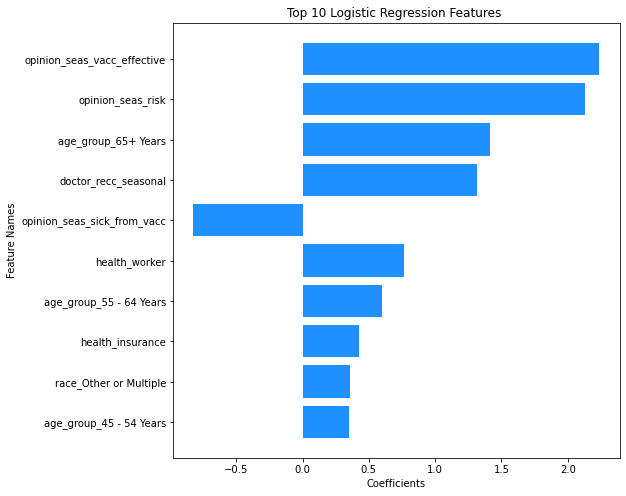

In [30]:
plot_importance(feature_names, coefficients, "Feature Names", "Coefficients",
               "Top 10 Logistic Regression Features ", num_features = 10)

All in all both our logistic regression models gave us around the same results - lets try some other models to see if we can improve on our models accuracy and how it values the features. 

## Random Forest Models

Lets use a `RandomForestClassifier`, which uses an initial weakly fitted model and then build on that to prevent overfitting, and then play around with its parameters.

In [31]:
# create baseline `RandomForestClassifier`(base_rf)
base_rfc_pipe = Pipeline(steps=[("preprocessing_pipe", preprocessing_pipe),
                                    ("base_rf", RandomForestClassifier(random_state = RANDOM_STATE))])

In [32]:
# call function to fit and report on model
report(base_rfc_pipe, X_train, y_train, X_test, y_test)

Training Accuracy :  99.83773325844099
Test Accuracy :  76.8251591164358
Training data matrix:
[[8510   13]
 [  13 7487]]
Training report matrix:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8523
           1       1.00      1.00      1.00      7500

    accuracy                           1.00     16023
   macro avg       1.00      1.00      1.00     16023
weighted avg       1.00      1.00      1.00     16023

Test data matrix:
[[2310  581]
 [ 657 1794]]


Once again, our classifier seems to have overfit, and does worse on the test data then we saw in the logistic regression. Let's try creating another `GridSearchCV` to correct the ovefitting and see if we can get a higher accuracy. 

In [33]:
#looking at the base parameters to inform our GridSearchCV params grid
base_rfc_pipe[1].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [34]:
# GridSearchCV to find the best parameters
param_grid = {
    # create a max depth to prevent overfitting 
    'base_rf__max_depth': [5, 6],
    # checking if lowing the number of estimators from 100 (default) will improve our predictions
    'base_rf__n_estimators': [90, 100],
    # try limiting leaf nodes
    'base_rf__max_leaf_nodes': [80, 100],
    # try bounding the number of samples needed to create a split
    'base_rf__min_samples_split': [4, 6]
}

gs = GridSearchCV(estimator=base_rfc_pipe,
                  param_grid=param_grid,
                  cv=5)


In [ ]:
# fit and print best parameters
gs.fit(X_train, y_train)
gs.best_params_

In [ ]:
# create optimized random forest pipeline
rfc_optimized_pipe = Pipeline(steps=[("preprocessing_pipe", preprocessing_pipe),
                                        ("rfc_optimized", RandomForestClassifier(random_state = RANDOM_STATE,
                                                                                 max_depth = 6,
                                                                                 max_leaf_nodes = 80,
                                                                                 min_samples_split = 4,
                                                                                 n_estimators = 100))])    

In [ ]:
# call function to fit and report on model
report(rfc_optimized_pipe, X_train, y_train, X_test, y_test)

In [ ]:
rfc_feature_import = rfc_optimized_pipe.named_steps["rfc_optimized"].feature_importances_

In [ ]:
#plot the data
plot_importance(feature_names, rfc_feature_import, "Feature Names", "Feature Importances", 
               "Top 10 Random Forest Features", num_features = 10)

It seems like our LogisticRegression Model did better than the random forest models we built. We'll try one more model.

## XGBoost Model

So in the final logreg_optimized_pipe we got 78.098% for accuracy on the test set - let's see if we can improve that by using an XGBoost model. XGBoost provides some of the best-in-class performance compared to other classification algorithms, so I figured it was worth checking it out here. 

In [ ]:
# create baseline XGB model pipeline
base_XGB_pipe = Pipeline(steps=[("preprocessing_pipe", preprocessing_pipe),
                               ("base_XGB", XGBClassifier(random_state = RANDOM_STATE,
                                                         use_label_encoder=False))])
# call function to fit and report on model
report(base_XGB_pipe, X_train, y_train, X_test, y_test)


So the test set is still performing around what we've seen in the earlier models, and our model seems a bit overfit to our data - lets try using `GridSearchCV` to find parameters that will work better. 


In [ ]:
# creating the parameters grid
param_grid = {
    'base_XGB__learning_rate': [0.1, 0.2],
    'base_XGB__max_depth': [3, 4],
    'base_XGB__min_child_weight': [2, 3],
    'base_XGB__subsample': [0.6, 0.7],
    'base_XGB__n_estimators': [75, 80],
}

In [ ]:
#perform GridSearchCV
grid_XGB = GridSearchCV(estimator=base_XGB_pipe,
                        scoring = "accuracy",
                        param_grid=param_grid,
                        cv=5)
grid_XGB.fit(X_train, y_train)

In [ ]:
grid_XGB.best_params_

In [ ]:
# create optimized_XGB_pipe
optimized_XGB_pipe = Pipeline(steps=[("preprocessing_pipe", preprocessing_pipe),
                      ("optimized_XGB", XGBClassifier(random_state = RANDOM_STATE,
                                                      use_label_encoder = False,
                                                      learning_rate =  0.2,
                                                      max_depth = 3,
                                                      min_child_weight = 3,
                                                      n_estimators = 75,
                                                      subsample = 0.7))])



In [ ]:
# call function to fit and report on model
report(optimized_XGB_pipe, X_train, y_train, X_test, y_test)

In [ ]:
# get feature importances
# https://9to5answer.com/feature-importance-with-xgbclassifier
xgb_fea_imp=pd.DataFrame(list(optimized_XGB_pipe[1].get_booster().get_fscore().items()))

In [ ]:
plot_importance(feature_names, xgb_fea_imp[1], "Feature Names", "Feature Importance (F-score)", 
                "Top 10 XGBClassifier Features", num_features =10)

As this model did best both on accuracy and (based on the graph) in handling the features, lets consider this our final model. As such, let check how our model performs on our validation set. 

In [ ]:
optimized_XGB_pipe.fit(X_train, y_train)

val_preds = optimized_XGB_pipe.predict(X_val)

val_accuracy = accuracy_score(y_val, val_preds)

print('Final model validation accuracy: {:.4}%'.format(val_accuracy * 100))

# Evaluation of Final Model 
Our final model is `optimized_XGB_pipe` as it gave us both the highest accuracy on the test data set, and it seemed to produced the most balanced feature importance results (see graph above) out of all of our models. 

While the `GridSearchCV` has a long runtime (as expected) the actual model runs fairly quickly. 

Our original goal was to find the most relevant features so as to give reccomendations for the creation of a new COVID-19 vaccine survey. The final model allows us to pull out the most relevant features and examine which ones we should use in COVID-19 vaccine compliance survey.

## Visualizations of Specific Features

We will take a quick glance at the best and worst feature according to our final model, in order to get a visual undestanding of why some features performed better than others. 

In [ ]:
# creating a DataFrame to make graphs
df = pd.concat([pd.DataFrame(features), pd.DataFrame(labels)], axis =1)
#df.head()

In [ ]:
# look into the top predictor on our XCGClassifier model 
counts = (df[['seasonal_vaccine', 'opinion_seas_risk']]
              .groupby(['seasonal_vaccine', 'opinion_seas_risk'])
              .size()
              .unstack('seasonal_vaccine')
         )
seasonal_risk_counts = counts.sum(axis='columns')
props = counts.div(seasonal_risk_counts, axis='index')

In [ ]:
# first graph
ax = counts.plot.barh(color = ["orange", "dodgerblue"])
ax.legend(
    loc='center left', 
    bbox_to_anchor=(1.05, 0.5),
    labels = ["No", "Yes"],
    title='Vaccinated')
plt.ylabel('Seasonal Flu Risk')
plt.xlabel('Response Count')
# set y-axes tick labels
ax.set_yticklabels(["Very Low", "Somewhat Low", "Don't Know",
                    "Somewhat High", "Very High"])
plt.title('Vaccination Count vs. Opinions on Seasonal Flu Risk');

In [ ]:
# Second graph
ax = props.plot.barh(stacked=True, color = ["orange", "dodgerblue"])
ax.legend(
    loc='center left', 
    bbox_to_anchor=(1.05, 0.5),
    labels = ["No", "Yes"],
    title='Vaccinated')
plt.ylabel('Seasonal Flu Risk')
plt.xlabel('Vaccination Rate')
# set y-axes tick labels
ax.set_yticklabels(["Very Low", "Somewhat Low", "Don't Know",
                    "Somewhat High", "Very High"])
plt.title('Vaccination Rate vs. Opinions on Seasonal Flu Risk');

In [ ]:
# look into the worst predictor on our XCGClassifier model 
counts = (df[['seasonal_vaccine', 'behavioral_large_gatherings']]
              .groupby(['seasonal_vaccine', 'behavioral_large_gatherings'])
              .size()
              .unstack('seasonal_vaccine')
         )
large_gathering_counts = counts.sum(axis='columns')
props = counts.div(large_gathering_counts, axis='index')

In [ ]:
# first graph
ax = counts.plot.barh(color = ["orange", "dodgerblue"])
ax.legend(
    loc='center left', 
    bbox_to_anchor=(1.05, 0.5),
    labels = ["No", "Yes"],
    title='Vaccinated')
plt.ylabel('Reduced Time at Large Gatherings')
plt.xlabel('Response Count')
# set y-axes tick labels
ax.set_yticklabels(["No", "Yes"])
plt.title('Vaccination Count vs. Reduced Large Gatherings');

In [ ]:
ax = props.plot.barh(stacked=True, color = ["orange", "dodgerblue"])
ax.legend(
    loc='center left', 
    bbox_to_anchor=(1.05, 0.5),
    labels = ["No", "Yes"],
    title='Vaccinated')
plt.ylabel('Reduced Time at Large Gatherings')
plt.xlabel('Vaccination Rate')
# set y-axes tick labels
ax.set_yticklabels(["No", "Yes"])
plt.title('Vaccination Rate vs. Reduced Large Gatherings');

# Reccomendations


Based on our final model, we see that questions about peoples **opinions** about vaccines was highly correlated to their **vaccination status**. As such, my first reccomendation would be to include these types of questions (e.g. "How likely are you to get sick if you don't get the vaccine?", "How effective are vaccines, in your opinion?", "How concerned are you about getting sick from the vaccine?") in the survey. 

The second reccomendation would be to ask for the repondants **age**, if their **health insurance** covers the vaccine (as everyone is now supposed to have health insurance in the U.S., unlike in 2009) and if their primary **doctor spoke to them** about getting the COVID-19 vaccine, as these questions were also shown in the model as relevant to vaccine compliance. 

My final reccomendation is to try and **limit the number of questions included in the survey**, in order to encourage and enable complete survey responses. This dataset included lots of missing data. By shortening the questionnaire, response compliance may be increased. 

Additionally, I'd like to suggest that the poor performance of the behavioral questions (e.g. "Have you avoided large gatherings? "Have you worn a mask?") in the final model is because, in 2009, the messaging around H1N1 didn't include these types of recommendations. These types of behavioral recommendations were much more prevalent throughout the COVID-19 pandemic. My intuition tells me that self-reports of these behaviors are likely to follow the stated opinions of respondents (if someone says they are worried about getting sick, then it is likely they will say they wear a mask) but this assumption should be further investigated. 